# 3.16 实战Kaggle比赛：房价预测

In [2]:
# 如果没有安装pandas，则反注释下面一行
# !pip install pandas

%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.9.0


## 3.16.2 获取和读取数据集

In [3]:
train_data = pd.read_csv('../../data/kaggle_house/train.csv')
test_data = pd.read_csv('../../data/kaggle_house/test.csv')

In [4]:
train_data.shape

(1460, 81)

In [6]:
train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
test_data.shape

(1459, 80)

In [7]:
test_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [8]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
all_features.shape

(2919, 79)

In [11]:
all_features.loc[0, "MSSubClass"]

0    60
0    20
Name: MSSubClass, dtype: int64

In [13]:
all_features.loc[0, "MSZoning"]

0    RL
0    RH
Name: MSZoning, dtype: object

## 3.16.3 预处理数据

In [25]:
# help(all_features.dtypes)
# all_features.dtypes

In [26]:
# all_features.dtypes[all_features.dtypes != 'object']

In [27]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [29]:
all_features[numeric_features].head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008


In [30]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [31]:
all_features[numeric_features].head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619


In [32]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [33]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

In [34]:
train_features.shape, test_features.shape, train_labels.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]), torch.Size([1460, 1]))

## 3.16.4 训练模型

In [43]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [44]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [45]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 3.16.5 $K$折交叉验证

In [46]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [47]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 3.16.6 模型选择

fold 0, train rmse 0.170324, valid rmse 0.156750
fold 1, train rmse 0.162024, valid rmse 0.189547
fold 2, train rmse 0.163867, valid rmse 0.168090
fold 3, train rmse 0.167765, valid rmse 0.154326
fold 4, train rmse 0.163120, valid rmse 0.183279
5-fold validation: avg train rmse 0.165420, avg valid rmse 0.170399


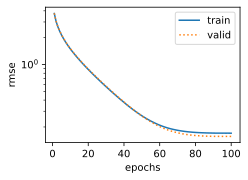

In [48]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

## 3.16.7 预测并在Kaggle提交结果

In [49]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # submission.to_csv('./submission.csv', index=False)

train rmse 0.162420


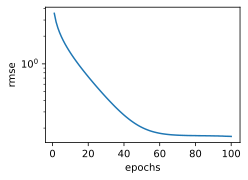

In [50]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)